# III. Model development
### 1. Denominate data 
###  2. Feature engineering
### 3. Create base model with no diabetic related features
### 4. Create enhanced model with adding diabetic related result and medication
### 5. Compare performance of different classifiers

In [1]:
import pandas as pd
import pandas_profiling
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz
from sklearn.metrics import roc_curve, auc

C:\Users\yafen\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## Import data from last data cleansing step

In [3]:
Diabetic_data_clean=pd.read_csv(r'D:\Yafen\study\UHG DSU\Optum scale data science\my project\dataset_diabetes\diabetic_data_clean_after_eda.csv')

C:\Users\yafen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
Diabetic_data_clean.shape

(66500, 26)

In [306]:
Diabetic_data_clean.head()

,Unnamed: 0,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted,discharge_disposition,admission_type,admission_source,diag_1_group,A1Ctaken,dosage_up,dosage_down,dosage_change,num_dosage_change
0,0,Caucasian,Female,<60,1,41,0,1,0,0,0,1,None,None,No,No,NO,Discharged to home,Emergency,Referral,Diabetes,0.0,0.0,0.0,Steady,0.0
1,1,Caucasian,Female,<60,3,59,0,18,0,0,0,9,None,None,Ch,Yes,>30,Discharged to home,Emergency,Referral,Other,0.0,1.0,0.0,Up,1.0
2,2,AfricanAmerican,Female,<60,2,11,5,13,2,0,1,6,None,None,No,Yes,NO,Discharged to home,Emergency,Referral,Other,0.0,0.0,0.0,Steady,0.0
3,3,Caucasian,Male,<60,2,44,1,16,0,0,0,7,None,None,Ch,Yes,NO,Discharged to home,Emergency,Referral,Other,0.0,1.0,0.0,Up,1.0
4,4,Caucasian,Male,<60,1,51,0,8,0,0,0,5,None,None,Ch,Yes,NO,Discharged to home,Emergency,Referral,Neoplasms,0.0,0.0,0.0,Steady,0.0


In [307]:
Diabetic_data_clean.drop(columns=['Unnamed: 0'],inplace=True)

In [308]:
Diabetic_data_clean.columns

Index(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'readmitted', 'discharge_disposition', 'admission_type', 'admission_source', 'diag_1_group', 'A1Ctaken', 'dosage_up', 'dosage_down', 'dosage_change', 'num_dosage_change'], dtype='object')

# 1. Denominate data

In [309]:
Diabetic_data_prep=Diabetic_data_clean.copy()

In [310]:
Diabetic_data_prep.shape

(66500, 25)

## 1.1 Remove readmitted >30 

In [311]:
Diabetic_data_prep=Diabetic_data_prep[Diabetic_data_prep['readmitted']!='>30']

In [312]:
Diabetic_data_prep.loc[Diabetic_data_prep['readmitted']=='<30','readmitted']=1
Diabetic_data_prep.loc[Diabetic_data_prep['readmitted']=='NO','readmitted']=0

In [313]:
Diabetic_data_prep.groupby('readmitted').size()

readmitted
0    39866
1     5800
dtype: int64

In [314]:
logit_score_compare_sampling=pd.DataFrame(columns=['Model','Accuracy','AUC','Precision','Recall'])

##  1.2 Balance readmitted

### Balance using undersampling

In [315]:
Diabetic_feature=['A1Ctaken','max_glu_serum', 'A1Cresult', 'change', 'diabetesMed','dosage_up','dosage_down','dosage_change','num_dosage_change']


In [316]:
Diabetic_data_prep_readmitted=Diabetic_data_prep[Diabetic_data_prep.readmitted==1]
Diabetic_data_prep_Not_readmitted=Diabetic_data_prep[Diabetic_data_prep.readmitted==0]
Diabetic_data_prep_Not_readmitted_balanced=Diabetic_data_prep_Not_readmitted.sample(len(Diabetic_data_prep_readmitted),random_state=1)
Diabetic_data_prep_balanced_under=pd.concat([Diabetic_data_prep_Not_readmitted_balanced,Diabetic_data_prep_readmitted])
Diabetic_data_prep_balanced_under=Diabetic_data_prep_balanced_under.reset_index(drop=True)

In [317]:
scaler = preprocessing.StandardScaler()

In [318]:
retained_categorical_feature=['race', 'gender', 'age', 'discharge_disposition', 'admission_type', 'admission_source', 'diag_1_group']
Diabetic_data_prep_x=Diabetic_data_prep_balanced_under.drop(columns=Diabetic_feature)
Diabetic_data_prep_x.drop(columns='readmitted',inplace=True)
Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
names = Diabetic_data_prep_x.columns
scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
Diabetic_data_prep_y=Diabetic_data_prep_balanced_under['readmitted']

In [319]:
scaled_Diabetic_data_prep_x.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,age_60-80,age_<60,age_>80,discharge_disposition_Discharged to home,discharge_disposition_Transfer to another health provider,discharge_disposition_UNK,admission_type_Elective,admission_type_Emergency,admission_type_Trauma Center,admission_type_UNK,admission_type_Urgent,admission_source_Emergency Room,admission_source_Referral,admission_source_Transfer from another provider,admission_source_UNK,diag_1_group_Circulatory,diag_1_group_Diabetes,diag_1_group_Digestive,diag_1_group_Genitourinary,diag_1_group_Injury,diag_1_group_Musculoskeletal,diag_1_group_Neoplasms,diag_1_group_Other,diag_1_group_Respiratory
0,-0.431107,-2.167441,-0.799225,-1.196589,-0.268563,-0.197294,-0.308292,-0.114371,-0.473849,-0.08793,0.58173,-0.146889,-0.120859,-1.066518,1.066518,-0.966759,-0.677177,1.984508,-1.162135,-0.403329,-0.17508,-0.383456,-0.824881,-0.013132,1.451409,-0.411527,-0.811082,-0.578412,-0.231283,1.521278,-0.653848,-0.300034,-0.312994,-0.231697,-0.287568,-0.246998,-0.203206,2.138748,-0.377667
1,1.076874,0.325579,2.802566,1.740839,-0.268563,-0.197294,-0.308292,-0.114371,-0.473849,-0.08793,0.58173,-0.146889,-0.120859,0.937631,-0.937631,1.034384,-0.677177,-0.503903,-1.162135,-0.403329,-0.17508,-0.383456,-0.824881,-0.013132,1.451409,-0.411527,-0.811082,-0.578412,-0.231283,1.521278,1.529409,-0.300034,-0.312994,-0.231697,-0.287568,-0.246998,-0.203206,-0.467563,-0.377667
2,-0.808103,0.585269,-0.799225,-0.423581,-0.268563,-0.197294,-0.308292,0.889566,-0.473849,-0.08793,0.58173,-0.146889,-0.120859,-1.066518,1.066518,1.034384,-0.677177,-0.503903,-1.162135,2.479366,-0.17508,-0.383456,-0.824881,-0.013132,-0.688986,2.429972,1.232922,-0.578412,-0.231283,-0.657342,-0.653848,-0.300034,-0.312994,-0.231697,-0.287568,-0.246998,-0.203206,-0.467563,2.647839
3,-1.185098,-2.115503,-0.799225,-0.732784,-0.268563,1.489227,-0.308292,0.889566,-0.473849,-0.08793,0.58173,-0.146889,-0.120859,-1.066518,1.066518,-0.966759,1.476718,-0.503903,-1.162135,-0.403329,-0.17508,-0.383456,-0.824881,-0.013132,1.451409,-0.411527,-0.811082,-0.578412,-0.231283,1.521278,-0.653848,-0.300034,-0.312994,-0.231697,-0.287568,-0.246998,-0.203206,-0.467563,2.647839
4,-1.185098,-2.115503,2.802566,-1.660393,-0.268563,-0.197294,-0.308292,-0.616339,-0.473849,-0.08793,0.58173,-0.146889,-0.120859,-1.066518,1.066518,-0.966759,1.476718,-0.503903,0.860485,-0.403329,-0.17508,2.607861,-0.824881,-0.013132,-0.688986,-0.411527,1.232922,-0.578412,-0.231283,-0.657342,1.529409,-0.300034,-0.312994,-0.231697,-0.287568,-0.246998,-0.203206,-0.467563,-0.377667


### Logistic regression for comparing model using undersampling target variable

In [320]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=2000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
logit_score_compare_sampling=logit_score_compare_sampling.append({'Model':'Base model with balanced target using undersampling','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

### Decision tree for comparing model using undersampling target variable

Text(0.5, 1.0, 'Balance readmitted using undersampling')

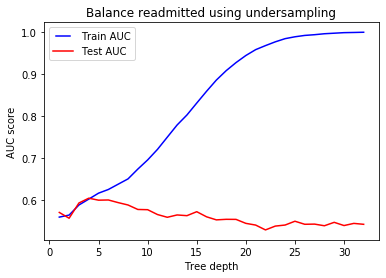

In [321]:
x_train, x_test, y_train, y_test = train_test_split(scaled_Diabetic_data_prep_x, Diabetic_data_prep_y, test_size=0.2,random_state=0)
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(x_train, y_train)
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
    test_results.append(roc_auc)

    from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.title('Balance readmitted using undersampling')

### Balance using upsampling

In [322]:
Diabetic_data_prep_readmitted=Diabetic_data_prep[Diabetic_data_prep.readmitted==1]
Diabetic_data_prep_Not_readmitted=Diabetic_data_prep[Diabetic_data_prep.readmitted==0]
Diabetic_data_prep_readmitted_up=Diabetic_data_prep_readmitted.sample(len(Diabetic_data_prep_Not_readmitted),replace=True)
Diabetic_data_prep_balanced_up=pd.concat([Diabetic_data_prep_readmitted_up,Diabetic_data_prep_Not_readmitted])
Diabetic_data_prep_balanced_up=Diabetic_data_prep_balanced_up.reset_index(drop=True)

In [323]:
Diabetic_data_prep_balanced_up.groupby('readmitted').size()

readmitted
0    39866
1    39866
dtype: int64

In [324]:
retained_categorical_feature=['race', 'gender', 'age', 'discharge_disposition', 'admission_type', 'admission_source', 'diag_1_group']
Diabetic_data_prep_x=Diabetic_data_prep_balanced_up.drop(columns=Diabetic_feature)
Diabetic_data_prep_x.drop(columns='readmitted',inplace=True)
Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
names = Diabetic_data_prep_x.columns
scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
Diabetic_data_prep_y=Diabetic_data_prep_balanced_up['readmitted']

### Logistic regression for comparing model using upsampling target variable

In [325]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=2000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
logit_score_compare_sampling=logit_score_compare_sampling.append({'Model':'Base model with balanced target using upsampling','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

### Decision tree for comparing model using upsampling target variable

Text(0.5, 1.0, 'Balance readmitted using upsampling')

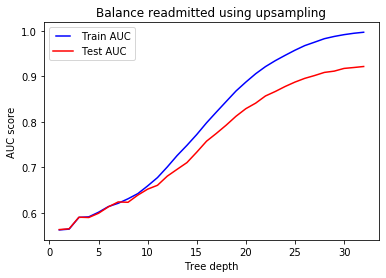

In [326]:
x_train, x_test, y_train, y_test = train_test_split(scaled_Diabetic_data_prep_x, Diabetic_data_prep_y, test_size=0.2,random_state=0)
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(x_train, y_train)
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
    test_results.append(roc_auc)

    from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.title('Balance readmitted using upsampling')

In [327]:
logit_score_compare_sampling[['Model','Accuracy','Precision','Recall']]

,Model,Accuracy,Precision,Recall
0,Base model with balanced target using undersam...,0.614397,0.582241,0.622271
1,Base model with balanced target using upsampling,0.616779,0.583329,0.625179


## Conclusion: using upsampling for balancing target variable compromise the independency between training and testing set and doesn't improve performance in significant way either. Therefore decided to use downsampling for balancing target variable

## 1.3 Balance gender 

In [328]:
Diabetic_data_prep_balanced_under.groupby(['readmitted','gender']).size()

readmitted  gender
0           Female    3058
            Male      2742
1           Female    3115
            Male      2685
dtype: int64

In [329]:
gender_sample_size=int(round(Diabetic_data_prep_balanced_under.groupby(['readmitted','gender']).size().min(),0))
gender_sample_size


2685

In [330]:
readmitted_female=Diabetic_data_prep_balanced_under[(Diabetic_data_prep_balanced_under.gender=='Female') & (Diabetic_data_prep_balanced_under.readmitted==1)].sample(gender_sample_size,random_state=1)
readmitted_male=Diabetic_data_prep_balanced_under[(Diabetic_data_prep_balanced_under.gender=='Male') & (Diabetic_data_prep_balanced_under.readmitted==1)]
No_female=Diabetic_data_prep_balanced_under[(Diabetic_data_prep_balanced_under.gender=='Female') & (Diabetic_data_prep_balanced_under.readmitted==0)].sample(gender_sample_size,random_state=1)
No_Male=Diabetic_data_prep_balanced_under[(Diabetic_data_prep_balanced_under.gender=='Male') & (Diabetic_data_prep_balanced_under.readmitted==0)].sample(gender_sample_size,random_state=1)

Diabetic_data_prep_balanced_readmitted_gender=pd.concat([readmitted_female,readmitted_male,No_female,No_Male])
Diabetic_data_prep_balanced_readmitted_gender=Diabetic_data_prep_balanced_readmitted_gender.reset_index(drop=True)

In [331]:
Diabetic_data_prep_balanced_readmitted_gender.groupby(['readmitted','gender']).size()

readmitted  gender
0           Female    2685
            Male      2685
1           Female    2685
            Male      2685
dtype: int64

## 1.4 Drop race, age group

In [332]:
Diabetic_data_denominated=Diabetic_data_prep_balanced_readmitted_gender.drop(columns=['age','race'])

# 2. Feature Engineering

In [333]:
Diabetic_data_denominated.loc[Diabetic_data_denominated.change=='No','change']=0
Diabetic_data_denominated.loc[Diabetic_data_denominated.change=='Ch','change']=1

Diabetic_data_denominated.loc[Diabetic_data_denominated.diabetesMed=='No','diabetesMed']=0
Diabetic_data_denominated.loc[Diabetic_data_denominated.diabetesMed=='Yes','diabetesMed']=1


### Statistical analysis

In [441]:
numeric_feature=['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses','num_dosage_change']

Diabetic_data_denominated[numeric_feature].corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,num_dosage_change
time_in_hospital,1.000000,0.302820,0.114571,0.425421,-0.022816,-0.017569,0.051736,0.225762,0.146582
num_lab_procedures,0.302820,1.000000,-0.003451,0.221242,0.002971,0.010711,0.087793,0.154687,0.117144
num_procedures,0.114571,-0.003451,1.000000,0.291694,0.001127,-0.025837,-0.034579,0.072538,-0.024483
num_medications,0.425421,0.221242,0.291694,1.000000,0.046856,0.002402,0.058890,0.277021,0.188298
number_outpatient,-0.022816,0.002971,0.001127,0.046856,1.000000,0.104840,0.061032,0.078255,0.030010
number_emergency,-0.017569,0.010711,-0.025837,0.002402,0.104840,1.000000,0.146533,0.058359,0.023713
number_inpatient,0.051736,0.087793,-0.034579,0.058890,0.061032,0.146533,1.000000,0.070053,0.017245
number_diagnoses,0.225762,0.154687,0.072538,0.277021,0.078255,0.058359,0.070053,1.000000,0.074109
num_dosage_change,0.146582,0.117144,-0.024483,0.188298,0.030010,0.023713,0.017245,0.074109,1.000000


### Anova one way

In [442]:
anova_test=pd.DataFrame(columns=['feature','statistic','p_value'])
for numeric in numeric_feature:
    readmitted=Diabetic_data_denominated[Diabetic_data_denominated.readmitted==1][numeric]
    non_readmitted=Diabetic_data_denominated[Diabetic_data_denominated.readmitted==0][numeric]
    #print(stats.f_oneway(readmitted, non_readmitted))
    statistic=stats.f_oneway(readmitted, non_readmitted)[0]
    p_value=stats.f_oneway(readmitted, non_readmitted)[1]
    anova_test=anova_test.append({'feature':numeric,'statistic':statistic,'p_value':p_value},ignore_index=True)

In [443]:
anova_test.sort_values('statistic',ascending=False)

,feature,statistic,p_value
6,number_inpatient,343.045963,2.058154e-75
7,number_diagnoses,163.415071,3.785463e-37
0,time_in_hospital,145.427887,2.839611e-33
3,num_medications,99.191709,2.891251e-23
1,num_lab_procedures,42.183168,8.678671e-11
5,number_emergency,41.253356,1.393769e-10
8,num_dosage_change,34.915585,3.547732e-09
4,number_outpatient,17.547796,2.824150e-05
2,num_procedures,4.863932,2.744487e-02


### chi square test 

In [432]:
nominal_feature=['max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'discharge_disposition', 'admission_type', 'admission_source', 'diag_1_group', 'A1Ctaken', 'dosage_up', 'dosage_down', 'dosage_change']

In [433]:
chi_square_test=pd.DataFrame(columns=['feature','chi_square','p_value'])
for nominal in nominal_feature:
    crosstab=pd.crosstab(
                        Diabetic_data_denominated[nominal],
                        Diabetic_data_denominated['readmitted'],
                        margins = False
                        )
    chi_square=stats.chi2_contingency(crosstab)[0]
    p_value=stats.chi2_contingency(crosstab)[1]
    chi_square_test=chi_square_test.append({'feature':nominal,'chi_square':chi_square,'p_value':p_value},ignore_index=True)

In [434]:
chi_square_test.sort_values('chi_square',ascending=False)

,feature,chi_square,p_value
6,admission_source,109.734958,1.251337e-23
5,admission_type,104.010901,1.376070e-21
3,diabetesMed,63.811203,1.369326e-15
7,diag_1_group,49.729062,4.607096e-08
11,dosage_change,47.839584,2.303612e-10
10,dosage_down,39.946562,2.610065e-10
2,change,25.996180,3.420936e-07
1,A1Cresult,8.507520,1.421070e-02
8,A1Ctaken,7.473856,6.260132e-03
9,dosage_up,4.417320,3.557587e-02


# 3. Create base model with no diabetic related features

In [334]:
Model_score=pd.DataFrame(columns=['Classifier','Model','Accuracy','AUC','Precision','Recall'])

In [335]:
Diabetic_feature=['A1Ctaken','max_glu_serum', 'A1Cresult', 'change', 'diabetesMed','dosage_up','dosage_down','dosage_change','num_dosage_change']


### Create dummy variable for categorical variable

In [336]:
#retained_categorical_feature=['race', 'gender', 'age', 'discharge_disposition', 'admission_type', 'admission_source', 'diag_1_group']
retained_categorical_feature=['gender', 'discharge_disposition', 'admission_type', 'admission_source', 'diag_1_group']
Diabetic_data_prep_x=Diabetic_data_denominated.drop(columns=Diabetic_feature)
Diabetic_data_prep_x.drop(columns='readmitted',inplace=True)
Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
names = Diabetic_data_prep_x.columns
scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
Diabetic_data_prep_y=Diabetic_data_denominated['readmitted']

## 3.1 Logistic regression with all the base features 

In [337]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=2000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
Model_score=Model_score.append({'Classifier':'Logistic','Model':'Base model with all features','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

In [338]:
Model_score

,Classifier,Model,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,0.613128,0.614045,0.570019,0.623999


## 3.2  Logistic regression with dropping one feature at a time 

In [339]:
retained_categorical_feature=['gender', 'discharge_disposition', 'admission_type', 'admission_source', 'diag_1_group']
orig_list=list(Diabetic_data_denominated.columns)
feature_list=[x for x in orig_list if x not in Diabetic_feature]
feature_list.remove('readmitted')
for column in feature_list:
    score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
    retained_categorical_feature=['gender', 'discharge_disposition', 'admission_type', 'admission_source', 'diag_1_group']
    Diabetic_data_prep_x=Diabetic_data_denominated.drop(columns=Diabetic_feature)
    Diabetic_data_prep_x=Diabetic_data_prep_x.drop(columns=['readmitted',column])
    if column in retained_categorical_feature:
        retained_categorical_feature.remove(column)
    else:
        retained_categorical_feature
    
    Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
    names = Diabetic_data_prep_x.columns
    scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
    scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
    Diabetic_data_prep_y=Diabetic_data_denominated['readmitted']
    
    cv_splits=StratifiedKFold(10,True,123)
    for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
        trainX=Diabetic_data_prep_x.iloc[train_index,]
        trainY=Diabetic_data_prep_y.iloc[train_index,]
    
        testX=Diabetic_data_prep_x.iloc[test_index,]
        testY=Diabetic_data_prep_y.iloc[test_index,]
    
        logisticModel=LogisticRegression(solver='lbfgs',max_iter=2000)
        logisticModel.fit(trainX,trainY)
        validation=logisticModel.predict(testX)
     
        fold_accuracy=accuracy_score(validation,testY)
        fold_precision=precision_score(validation,testY)
        fold_recall=recall_score(validation,testY)
        fold_auc=roc_auc_score(validation,testY)
        score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)   
    
    Model_score=Model_score.append({'Classifier':'Logistic','Model':'Base model with dropping '+column,'Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)   
    

In [340]:
Model_score.sort_values('Accuracy',ascending=False)

,Classifier,Model,Accuracy,AUC,Precision,Recall
3,Logistic,Base model with dropping num_lab_procedures,0.614525,0.615451,0.571695,0.625487
12,Logistic,Base model with dropping admission_source,0.613780,0.614699,0.570764,0.624662
1,Logistic,Base model with dropping gender,0.613501,0.614448,0.569460,0.624633
5,Logistic,Base model with dropping num_medications,0.613408,0.614390,0.570764,0.624387
6,Logistic,Base model with dropping number_outpatient,0.613315,0.614218,0.570764,0.624123
0,Logistic,Base model with all features,0.613128,0.614045,0.570019,0.623999
11,Logistic,Base model with dropping admission_type,0.612384,0.613294,0.570391,0.622974
10,Logistic,Base model with dropping discharge_disposition,0.611173,0.612262,0.563128,0.623154
7,Logistic,Base model with dropping number_emergency,0.610987,0.611907,0.567784,0.621681
2,Logistic,Base model with dropping time_in_hospital,0.609777,0.610618,0.567784,0.619807


### Conclusion: dropping each feature at a time doesn't improve the model performance signficantly. Final base model would be model with all base features kept.  

## 3.3 Evaluate final logistic base model per each diagnosis

In [341]:
Model_by_diag_score=pd.DataFrame(columns=['Classifier','Model','Diag','Accuracy','AUC','Precision','Recall'])

In [342]:
Diabetic_feature=['A1Ctaken','max_glu_serum', 'A1Cresult', 'change', 'diabetesMed','dosage_up','dosage_down','dosage_change','num_dosage_change']

In [343]:
#retained_categorical_feature=['race', 'gender', 'age', 'discharge_disposition', 'admission_type', 'admission_source', 'diag_1_group']
retained_categorical_feature=['gender', 'discharge_disposition', 'admission_type', 'admission_source', 'diag_1_group']
Diabetic_data_prep_x=Diabetic_data_denominated.drop(columns=Diabetic_feature)
Diabetic_data_prep_x.drop(columns='readmitted',inplace=True)
Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
names = Diabetic_data_prep_x.columns
scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
Diabetic_data_prep_y=Diabetic_data_denominated['readmitted']

In [344]:
diagnosis=['diag_1_group_Circulatory', 'diag_1_group_Diabetes', 'diag_1_group_Digestive', 'diag_1_group_Genitourinary', 'diag_1_group_Injury', 'diag_1_group_Musculoskeletal', 'diag_1_group_Neoplasms', 'diag_1_group_Other', 'diag_1_group_Respiratory']
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=2000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    Result=pd.DataFrame(list(zip(list(validation),list(testY))),columns=['pred','true'])
    Diag=testX[diagnosis].reset_index()
    diag_result=pd.concat([Diag,Result], axis=1)
    diag_result.drop(columns='index',inplace=True)

    for diag in diagnosis:
        diag_result_s=diag_result[diag_result[diag]==1]
        validation_s=diag_result_s['pred']
        testY_s=diag_result_s['true']
        fold_accuracy_s=accuracy_score(validation_s,testY_s)
        fold_precision_s=precision_score(validation_s,testY_s)
        fold_recall_s=recall_score(validation_s,testY_s)
        fold_auc_s=roc_auc_score(validation_s,testY_s)
        
        score_s=score_s.append({'Diag':diag,'Accuracy':fold_accuracy_s,'AUC':fold_auc_s,'Precision':fold_precision_s,'Recall':fold_recall_s},ignore_index=True)

socre_diag=score_s.groupby('Diag').mean().reset_index()
socre_diag['Classifier']='Logistic'
socre_diag['Model']='Base model with all features'
Model_by_diag_score=Model_by_diag_score.append(socre_diag[['Classifier','Model','Diag','Accuracy','AUC','Precision','Recall']], ignore_index = True)       
 

In [345]:
Model_by_diag_score.sort_values('Accuracy',ascending=False)

,Classifier,Model,Diag,Accuracy,AUC,Precision,Recall
1,Logistic,Base model with all features,diag_1_group_Diabetes,0.663059,0.665102,0.632169,0.680144
8,Logistic,Base model with all features,diag_1_group_Respiratory,0.637649,0.638889,0.434524,0.642526
2,Logistic,Base model with all features,diag_1_group_Digestive,0.627938,0.632622,0.526724,0.642456
5,Logistic,Base model with all features,diag_1_group_Musculoskeletal,0.614528,0.617396,0.446809,0.619986
7,Logistic,Base model with all features,diag_1_group_Other,0.613052,0.616580,0.523839,0.629145
3,Logistic,Base model with all features,diag_1_group_Genitourinary,0.610273,0.610131,0.579634,0.604592
0,Logistic,Base model with all features,diag_1_group_Circulatory,0.602752,0.599978,0.668356,0.621599
4,Logistic,Base model with all features,diag_1_group_Injury,0.575649,0.572113,0.666484,0.594265
6,Logistic,Base model with all features,diag_1_group_Neoplasms,0.552575,0.532816,0.248617,0.487228


# 4 Enhanced model with adding diabetic related result and medication

### 4.1 Logistic regression with adding A1result

In [346]:
Diabetic_feature=['max_glu_serum', 'A1Ctaken', 'change', 'diabetesMed','dosage_up','dosage_down','dosage_change','num_dosage_change']


In [347]:
retained_categorical_feature=[ 'discharge_disposition', 'admission_source', 'diag_1_group','gender','admission_type','A1Cresult',]
Diabetic_data_prep_x=Diabetic_data_denominated.drop(columns='readmitted')
Diabetic_data_prep_x=Diabetic_data_prep_x.drop(columns=Diabetic_feature)
Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
names = Diabetic_data_prep_x.columns
scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
Diabetic_data_prep_y=Diabetic_data_denominated['readmitted']

In [348]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=2000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
Model_score=Model_score.append({'Classifier':'Logistic','Model':'Enhanced model with adding A1Cresult','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

In [349]:
Model_score

,Classifier,Model,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,0.613128,0.614045,0.570019,0.623999
1,Logistic,Base model with dropping gender,0.613501,0.614448,0.569460,0.624633
2,Logistic,Base model with dropping time_in_hospital,0.609777,0.610618,0.567784,0.619807
3,Logistic,Base model with dropping num_lab_procedures,0.614525,0.615451,0.571695,0.625487
4,Logistic,Base model with dropping num_procedures,0.609777,0.610659,0.566480,0.620272
5,Logistic,Base model with dropping num_medications,0.613408,0.614390,0.570764,0.624387
6,Logistic,Base model with dropping number_outpatient,0.613315,0.614218,0.570764,0.624123
7,Logistic,Base model with dropping number_emergency,0.610987,0.611907,0.567784,0.621681
8,Logistic,Base model with dropping number_inpatient,0.597114,0.597234,0.594227,0.597983
9,Logistic,Base model with dropping number_diagnoses,0.603352,0.605208,0.537989,0.619027


### Evaluate model accuracy per each diagnosis

In [350]:
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])

In [351]:
diagnosis=['diag_1_group_Circulatory', 'diag_1_group_Diabetes', 'diag_1_group_Digestive', 'diag_1_group_Genitourinary', 'diag_1_group_Injury', 'diag_1_group_Musculoskeletal', 'diag_1_group_Neoplasms', 'diag_1_group_Other', 'diag_1_group_Respiratory']
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=1000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    result=pd.DataFrame(list(zip(list(validation),list(testY))),columns=['pred','true'])
    Diag=testX[diagnosis].reset_index()
    diag_result=pd.concat([Diag,result], axis=1)
    diag_result.drop(columns='index',inplace=True)

    for diag in diagnosis:
        diag_result_s=diag_result[diag_result[diag]==1]
        validation_s=diag_result_s['pred']
        testY_s=diag_result_s['true']
        fold_accuracy_s=accuracy_score(validation_s,testY_s)
        fold_precision_s=precision_score(validation_s,testY_s)
        fold_recall_s=recall_score(validation_s,testY_s)
        fold_auc_s=roc_auc_score(validation_s,testY_s)
        
        score_s=score_s.append({'Diag':diag,'Accuracy':fold_accuracy_s,'AUC':fold_auc_s,'Precision':fold_precision_s,'Recall':fold_recall_s},ignore_index=True)

socre_diag=score_s.groupby('Diag').mean().reset_index()
socre_diag['Classifier']='Logistic'
socre_diag['Model']='Enhanced model with A1Cresult'
Model_by_diag_score=Model_by_diag_score.append(socre_diag[['Classifier','Model','Diag','Accuracy','AUC','Precision','Recall']], ignore_index = True)       
 

In [352]:
Model_by_diag_score.sort_values('Diag')

,Classifier,Model,Diag,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,diag_1_group_Circulatory,0.602752,0.599978,0.668356,0.621599
9,Logistic,Enhanced model with A1Cresult,diag_1_group_Circulatory,0.601293,0.598583,0.667848,0.620037
1,Logistic,Base model with all features,diag_1_group_Diabetes,0.663059,0.665102,0.632169,0.680144
10,Logistic,Enhanced model with A1Cresult,diag_1_group_Diabetes,0.671873,0.673901,0.642760,0.687633
2,Logistic,Base model with all features,diag_1_group_Digestive,0.627938,0.632622,0.526724,0.642456
11,Logistic,Enhanced model with A1Cresult,diag_1_group_Digestive,0.622727,0.625975,0.521475,0.633118
3,Logistic,Base model with all features,diag_1_group_Genitourinary,0.610273,0.610131,0.579634,0.604592
12,Logistic,Enhanced model with A1Cresult,diag_1_group_Genitourinary,0.616516,0.616522,0.585390,0.611413
4,Logistic,Base model with all features,diag_1_group_Injury,0.575649,0.572113,0.666484,0.594265
13,Logistic,Enhanced model with A1Cresult,diag_1_group_Injury,0.578090,0.574056,0.671009,0.595515


### 4.2 Logistic regression with adding A1Ctaken

In [353]:
Diabetic_feature=['max_glu_serum', 'A1Cresult', 'change', 'diabetesMed','dosage_up','dosage_down','dosage_change','num_dosage_change']


In [354]:
retained_categorical_feature=[ 'discharge_disposition', 'admission_source', 'diag_1_group','gender','admission_type']
Diabetic_data_prep_x=Diabetic_data_denominated.drop(columns='readmitted')
Diabetic_data_prep_x=Diabetic_data_prep_x.drop(columns=Diabetic_feature)
Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
names = Diabetic_data_prep_x.columns
scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
Diabetic_data_prep_y=Diabetic_data_denominated['readmitted']

In [355]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=2000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
Model_score=Model_score.append({'Classifier':'Logistic','Model':'Enhanced model with adding A1Ctaken','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

In [356]:
Model_score

,Classifier,Model,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,0.613128,0.614045,0.570019,0.623999
1,Logistic,Base model with dropping gender,0.613501,0.614448,0.569460,0.624633
2,Logistic,Base model with dropping time_in_hospital,0.609777,0.610618,0.567784,0.619807
3,Logistic,Base model with dropping num_lab_procedures,0.614525,0.615451,0.571695,0.625487
4,Logistic,Base model with dropping num_procedures,0.609777,0.610659,0.566480,0.620272
5,Logistic,Base model with dropping num_medications,0.613408,0.614390,0.570764,0.624387
6,Logistic,Base model with dropping number_outpatient,0.613315,0.614218,0.570764,0.624123
7,Logistic,Base model with dropping number_emergency,0.610987,0.611907,0.567784,0.621681
8,Logistic,Base model with dropping number_inpatient,0.597114,0.597234,0.594227,0.597983
9,Logistic,Base model with dropping number_diagnoses,0.603352,0.605208,0.537989,0.619027


### Evaluate model accuracy per each diagnosis

In [357]:
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])

In [358]:
diagnosis=['diag_1_group_Circulatory', 'diag_1_group_Diabetes', 'diag_1_group_Digestive', 'diag_1_group_Genitourinary', 'diag_1_group_Injury', 'diag_1_group_Musculoskeletal', 'diag_1_group_Neoplasms', 'diag_1_group_Other', 'diag_1_group_Respiratory']
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=1000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    result=pd.DataFrame(list(zip(list(validation),list(testY))),columns=['pred','true'])
    Diag=testX[diagnosis].reset_index()
    diag_result=pd.concat([Diag,result], axis=1)
    diag_result.drop(columns='index',inplace=True)

    for diag in diagnosis:
        diag_result_s=diag_result[diag_result[diag]==1]
        validation_s=diag_result_s['pred']
        testY_s=diag_result_s['true']
        fold_accuracy_s=accuracy_score(validation_s,testY_s)
        fold_precision_s=precision_score(validation_s,testY_s)
        fold_recall_s=recall_score(validation_s,testY_s)
        fold_auc_s=roc_auc_score(validation_s,testY_s)
        
        score_s=score_s.append({'Diag':diag,'Accuracy':fold_accuracy_s,'AUC':fold_auc_s,'Precision':fold_precision_s,'Recall':fold_recall_s},ignore_index=True)

socre_diag=score_s.groupby('Diag').mean().reset_index()
socre_diag['Classifier']='Logistic'
socre_diag['Model']='Enhanced model with A1Ctaken'
Model_by_diag_score=Model_by_diag_score.append(socre_diag[['Classifier','Model','Diag','Accuracy','AUC','Precision','Recall']], ignore_index = True)       
 

In [359]:
Model_by_diag_score.sort_values('Diag')

,Classifier,Model,Diag,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,diag_1_group_Circulatory,0.602752,0.599978,0.668356,0.621599
18,Logistic,Enhanced model with A1Ctaken,diag_1_group_Circulatory,0.600894,0.598123,0.666524,0.619881
9,Logistic,Enhanced model with A1Cresult,diag_1_group_Circulatory,0.601293,0.598583,0.667848,0.620037
1,Logistic,Base model with all features,diag_1_group_Diabetes,0.663059,0.665102,0.632169,0.680144
19,Logistic,Enhanced model with A1Ctaken,diag_1_group_Diabetes,0.673089,0.675504,0.644874,0.688898
10,Logistic,Enhanced model with A1Cresult,diag_1_group_Diabetes,0.671873,0.673901,0.642760,0.687633
2,Logistic,Base model with all features,diag_1_group_Digestive,0.627938,0.632622,0.526724,0.642456
20,Logistic,Enhanced model with A1Ctaken,diag_1_group_Digestive,0.623960,0.626961,0.523451,0.633844
11,Logistic,Enhanced model with A1Cresult,diag_1_group_Digestive,0.622727,0.625975,0.521475,0.633118
3,Logistic,Base model with all features,diag_1_group_Genitourinary,0.610273,0.610131,0.579634,0.604592


###  4.3 Logistic regression with adding A1Ctaken, diabetic medicine

In [360]:
Diabetic_feature=['change','max_glu_serum', 'A1Cresult','dosage_up','dosage_down','dosage_change','num_dosage_change']

In [361]:
retained_categorical_feature=[ 'discharge_disposition', 'admission_source', 'diag_1_group','gender','admission_type']
Diabetic_data_prep_x=Diabetic_data_denominated.drop(columns='readmitted')
Diabetic_data_prep_x=Diabetic_data_prep_x.drop(columns=Diabetic_feature)
Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
names = Diabetic_data_prep_x.columns
scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
Diabetic_data_prep_y=Diabetic_data_denominated['readmitted']

In [362]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=1000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
Model_score=Model_score.append({'Classifier':'Logistic','Model':'Enhanced model with A1Ctaken and diabetesMed','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

In [363]:
Model_score

,Classifier,Model,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,0.613128,0.614045,0.570019,0.623999
1,Logistic,Base model with dropping gender,0.613501,0.614448,0.569460,0.624633
2,Logistic,Base model with dropping time_in_hospital,0.609777,0.610618,0.567784,0.619807
3,Logistic,Base model with dropping num_lab_procedures,0.614525,0.615451,0.571695,0.625487
4,Logistic,Base model with dropping num_procedures,0.609777,0.610659,0.566480,0.620272
5,Logistic,Base model with dropping num_medications,0.613408,0.614390,0.570764,0.624387
6,Logistic,Base model with dropping number_outpatient,0.613315,0.614218,0.570764,0.624123
7,Logistic,Base model with dropping number_emergency,0.610987,0.611907,0.567784,0.621681
8,Logistic,Base model with dropping number_inpatient,0.597114,0.597234,0.594227,0.597983
9,Logistic,Base model with dropping number_diagnoses,0.603352,0.605208,0.537989,0.619027


### Evaluate model accuracy per each diagnosis

In [364]:
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])

In [365]:
diagnosis=['diag_1_group_Circulatory', 'diag_1_group_Diabetes', 'diag_1_group_Digestive', 'diag_1_group_Genitourinary', 'diag_1_group_Injury', 'diag_1_group_Musculoskeletal', 'diag_1_group_Neoplasms', 'diag_1_group_Other', 'diag_1_group_Respiratory']
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=1000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    result=pd.DataFrame(list(zip(list(validation),list(testY))),columns=['pred','true'])
    Diag=testX[diagnosis].reset_index()
    diag_result=pd.concat([Diag,result], axis=1)
    diag_result.drop(columns='index',inplace=True)

    for diag in diagnosis:
        diag_result_s=diag_result[diag_result[diag]==1]
        validation_s=diag_result_s['pred']
        testY_s=diag_result_s['true']
        fold_accuracy_s=accuracy_score(validation_s,testY_s)
        fold_precision_s=precision_score(validation_s,testY_s)
        fold_recall_s=recall_score(validation_s,testY_s)
        fold_auc_s=roc_auc_score(validation_s,testY_s)
        
        score_s=score_s.append({'Diag':diag,'Accuracy':fold_accuracy_s,'AUC':fold_auc_s,'Precision':fold_precision_s,'Recall':fold_recall_s},ignore_index=True)

socre_diag=score_s.groupby('Diag').mean().reset_index()
socre_diag['Classifier']='Logistic'
socre_diag['Model']='Enhanced model with A1Ctaken,diabetesMed'
Model_by_diag_score=Model_by_diag_score.append(socre_diag[['Classifier','Model','Diag','Accuracy','AUC','Precision','Recall']], ignore_index = True)       
 

In [366]:
Model_by_diag_score.sort_values('Diag')

,Classifier,Model,Diag,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,diag_1_group_Circulatory,0.602752,0.599978,0.668356,0.621599
9,Logistic,Enhanced model with A1Cresult,diag_1_group_Circulatory,0.601293,0.598583,0.667848,0.620037
27,Logistic,"Enhanced model with A1Ctaken,diabetesMed",diag_1_group_Circulatory,0.604638,0.601710,0.675824,0.621795
18,Logistic,Enhanced model with A1Ctaken,diag_1_group_Circulatory,0.600894,0.598123,0.666524,0.619881
28,Logistic,"Enhanced model with A1Ctaken,diabetesMed",diag_1_group_Diabetes,0.661154,0.664244,0.615681,0.684776
1,Logistic,Base model with all features,diag_1_group_Diabetes,0.663059,0.665102,0.632169,0.680144
10,Logistic,Enhanced model with A1Cresult,diag_1_group_Diabetes,0.671873,0.673901,0.642760,0.687633
19,Logistic,Enhanced model with A1Ctaken,diag_1_group_Diabetes,0.673089,0.675504,0.644874,0.688898
29,Logistic,"Enhanced model with A1Ctaken,diabetesMed",diag_1_group_Digestive,0.617670,0.620728,0.526709,0.626966
2,Logistic,Base model with all features,diag_1_group_Digestive,0.627938,0.632622,0.526724,0.642456


###  4.4 Logistic regression with adding A1Ctaken, diabetesMed, change

In [367]:
Diabetic_feature=['max_glu_serum', 'A1Cresult','dosage_up','dosage_down','dosage_change','num_dosage_change']

In [368]:
retained_categorical_feature=[ 'discharge_disposition', 'admission_source', 'diag_1_group','gender','admission_type']
Diabetic_data_prep_x=Diabetic_data_denominated.drop(columns='readmitted')
Diabetic_data_prep_x=Diabetic_data_prep_x.drop(columns=Diabetic_feature)
Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
names = Diabetic_data_prep_x.columns
scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
Diabetic_data_prep_y=Diabetic_data_denominated['readmitted']

In [369]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=2000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
Model_score=Model_score.append({'Classifier':'Logistic','Model':'Enhanced model with A1Ctaken,diabetesMed,change','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

In [370]:
Model_score

,Classifier,Model,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,0.613128,0.614045,0.570019,0.623999
1,Logistic,Base model with dropping gender,0.613501,0.614448,0.569460,0.624633
2,Logistic,Base model with dropping time_in_hospital,0.609777,0.610618,0.567784,0.619807
3,Logistic,Base model with dropping num_lab_procedures,0.614525,0.615451,0.571695,0.625487
4,Logistic,Base model with dropping num_procedures,0.609777,0.610659,0.566480,0.620272
5,Logistic,Base model with dropping num_medications,0.613408,0.614390,0.570764,0.624387
6,Logistic,Base model with dropping number_outpatient,0.613315,0.614218,0.570764,0.624123
7,Logistic,Base model with dropping number_emergency,0.610987,0.611907,0.567784,0.621681
8,Logistic,Base model with dropping number_inpatient,0.597114,0.597234,0.594227,0.597983
9,Logistic,Base model with dropping number_diagnoses,0.603352,0.605208,0.537989,0.619027


### Evaluate model accuracy per each diagnosis

In [371]:
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])

In [372]:
diagnosis=['diag_1_group_Circulatory', 'diag_1_group_Diabetes', 'diag_1_group_Digestive', 'diag_1_group_Genitourinary', 'diag_1_group_Injury', 'diag_1_group_Musculoskeletal', 'diag_1_group_Neoplasms', 'diag_1_group_Other', 'diag_1_group_Respiratory']
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=1000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    result=pd.DataFrame(list(zip(list(validation),list(testY))),columns=['pred','true'])
    Diag=testX[diagnosis].reset_index()
    diag_result=pd.concat([Diag,result], axis=1)
    diag_result.drop(columns='index',inplace=True)

    for diag in diagnosis:
        diag_result_s=diag_result[diag_result[diag]==1]
        validation_s=diag_result_s['pred']
        testY_s=diag_result_s['true']
        fold_accuracy_s=accuracy_score(validation_s,testY_s)
        fold_precision_s=precision_score(validation_s,testY_s)
        fold_recall_s=recall_score(validation_s,testY_s)
        fold_auc_s=roc_auc_score(validation_s,testY_s)
        
        score_s=score_s.append({'Diag':diag,'Accuracy':fold_accuracy_s,'AUC':fold_auc_s,'Precision':fold_precision_s,'Recall':fold_recall_s},ignore_index=True)

socre_diag=score_s.groupby('Diag').mean().reset_index()
socre_diag['Classifier']='Logistic'
socre_diag['Model']='Enhanced model with A1Ctaken,diabetesMed,change'
Model_by_diag_score=Model_by_diag_score.append(socre_diag[['Classifier','Model','Diag','Accuracy','AUC','Precision','Recall']], ignore_index = True)       
 

In [373]:
Model_by_diag_score.sort_values('Diag')

,Classifier,Model,Diag,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,diag_1_group_Circulatory,0.602752,0.599978,0.668356,0.621599
18,Logistic,Enhanced model with A1Ctaken,diag_1_group_Circulatory,0.600894,0.598123,0.666524,0.619881
27,Logistic,"Enhanced model with A1Ctaken,diabetesMed",diag_1_group_Circulatory,0.604638,0.601710,0.675824,0.621795
9,Logistic,Enhanced model with A1Cresult,diag_1_group_Circulatory,0.601293,0.598583,0.667848,0.620037
36,Logistic,"Enhanced model with A1Ctaken,diabetesMed,change",diag_1_group_Circulatory,0.604270,0.601292,0.675157,0.621415
19,Logistic,Enhanced model with A1Ctaken,diag_1_group_Diabetes,0.673089,0.675504,0.644874,0.688898
28,Logistic,"Enhanced model with A1Ctaken,diabetesMed",diag_1_group_Diabetes,0.661154,0.664244,0.615681,0.684776
10,Logistic,Enhanced model with A1Cresult,diag_1_group_Diabetes,0.671873,0.673901,0.642760,0.687633
1,Logistic,Base model with all features,diag_1_group_Diabetes,0.663059,0.665102,0.632169,0.680144
37,Logistic,"Enhanced model with A1Ctaken,diabetesMed,change",diag_1_group_Diabetes,0.655423,0.658974,0.608408,0.679320


###  4.5 Logistic regression with adding A1Ctaken,diabetesMed,change,num_dosage_change

In [374]:
Diabetic_feature=['max_glu_serum', 'A1Cresult','dosage_up','dosage_down','dosage_change']

In [375]:
retained_categorical_feature=[ 'discharge_disposition', 'admission_source', 'diag_1_group','gender','admission_type']
Diabetic_data_prep_x=Diabetic_data_denominated.drop(columns='readmitted')
Diabetic_data_prep_x=Diabetic_data_prep_x.drop(columns=Diabetic_feature)
Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
names = Diabetic_data_prep_x.columns
scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
Diabetic_data_prep_y=Diabetic_data_denominated['readmitted']

In [376]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=2000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
Model_score=Model_score.append({'Classifier':'Logistic','Model':'Enhanced model with A1Ctaken,diabetesMed,change, num_dosage_change','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

In [377]:
Model_score

,Classifier,Model,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,0.613128,0.614045,0.570019,0.623999
1,Logistic,Base model with dropping gender,0.613501,0.614448,0.569460,0.624633
2,Logistic,Base model with dropping time_in_hospital,0.609777,0.610618,0.567784,0.619807
3,Logistic,Base model with dropping num_lab_procedures,0.614525,0.615451,0.571695,0.625487
4,Logistic,Base model with dropping num_procedures,0.609777,0.610659,0.566480,0.620272
5,Logistic,Base model with dropping num_medications,0.613408,0.614390,0.570764,0.624387
6,Logistic,Base model with dropping number_outpatient,0.613315,0.614218,0.570764,0.624123
7,Logistic,Base model with dropping number_emergency,0.610987,0.611907,0.567784,0.621681
8,Logistic,Base model with dropping number_inpatient,0.597114,0.597234,0.594227,0.597983
9,Logistic,Base model with dropping number_diagnoses,0.603352,0.605208,0.537989,0.619027


### Evaluate model accuracy per each diagnosis

In [378]:
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])

In [379]:
diagnosis=['diag_1_group_Circulatory', 'diag_1_group_Diabetes', 'diag_1_group_Digestive', 'diag_1_group_Genitourinary', 'diag_1_group_Injury', 'diag_1_group_Musculoskeletal', 'diag_1_group_Neoplasms', 'diag_1_group_Other', 'diag_1_group_Respiratory']
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=1000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    result=pd.DataFrame(list(zip(list(validation),list(testY))),columns=['pred','true'])
    Diag=testX[diagnosis].reset_index()
    diag_result=pd.concat([Diag,result], axis=1)
    diag_result.drop(columns='index',inplace=True)

    for diag in diagnosis:
        diag_result_s=diag_result[diag_result[diag]==1]
        validation_s=diag_result_s['pred']
        testY_s=diag_result_s['true']
        fold_accuracy_s=accuracy_score(validation_s,testY_s)
        fold_precision_s=precision_score(validation_s,testY_s)
        fold_recall_s=recall_score(validation_s,testY_s)
        fold_auc_s=roc_auc_score(validation_s,testY_s)
        
        score_s=score_s.append({'Diag':diag,'Accuracy':fold_accuracy_s,'AUC':fold_auc_s,'Precision':fold_precision_s,'Recall':fold_recall_s},ignore_index=True)

socre_diag=score_s.groupby('Diag').mean().reset_index()
socre_diag['Classifier']='Logistic'
socre_diag['Model']='Enhanced model with A1Ctaken,diabetesMed,change,num_dosage_change'
Model_by_diag_score=Model_by_diag_score.append(socre_diag[['Classifier','Model','Diag','Accuracy','AUC','Precision','Recall']], ignore_index = True)       
 

In [380]:
Model_by_diag_score.sort_values('Diag')

,Classifier,Model,Diag,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,diag_1_group_Circulatory,0.602752,0.599978,0.668356,0.621599
45,Logistic,"Enhanced model with A1Ctaken,diabetesMed,chang...",diag_1_group_Circulatory,0.606359,0.603308,0.676641,0.623362
36,Logistic,"Enhanced model with A1Ctaken,diabetesMed,change",diag_1_group_Circulatory,0.604270,0.601292,0.675157,0.621415
27,Logistic,"Enhanced model with A1Ctaken,diabetesMed",diag_1_group_Circulatory,0.604638,0.601710,0.675824,0.621795
9,Logistic,Enhanced model with A1Cresult,diag_1_group_Circulatory,0.601293,0.598583,0.667848,0.620037
18,Logistic,Enhanced model with A1Ctaken,diag_1_group_Circulatory,0.600894,0.598123,0.666524,0.619881
1,Logistic,Base model with all features,diag_1_group_Diabetes,0.663059,0.665102,0.632169,0.680144
37,Logistic,"Enhanced model with A1Ctaken,diabetesMed,change",diag_1_group_Diabetes,0.655423,0.658974,0.608408,0.679320
28,Logistic,"Enhanced model with A1Ctaken,diabetesMed",diag_1_group_Diabetes,0.661154,0.664244,0.615681,0.684776
10,Logistic,Enhanced model with A1Cresult,diag_1_group_Diabetes,0.671873,0.673901,0.642760,0.687633


###  4.6 Logistic regression with adding A1Ctaken,diabetesMed,change,num_dosage_change,dosage_up,dosage_down

In [444]:
Diabetic_feature=['max_glu_serum', 'A1Cresult','dosage_change']

In [445]:
retained_categorical_feature=[ 'discharge_disposition', 'admission_source', 'diag_1_group','gender','admission_type']
Diabetic_data_prep_x=Diabetic_data_denominated.drop(columns='readmitted')
Diabetic_data_prep_x=Diabetic_data_prep_x.drop(columns=Diabetic_feature)
Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
names = Diabetic_data_prep_x.columns
scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
Diabetic_data_prep_y=Diabetic_data_denominated['readmitted']

In [446]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=2000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
Model_score=Model_score.append({'Classifier':'Logistic','Model':'Enhanced model with A1Ctaken,diabetesMed,change, num_dosage_change','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

In [447]:
Model_score

,Classifier,Model,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,0.613128,0.614045,0.570019,0.623999
1,Logistic,Base model with dropping gender,0.613501,0.614448,0.569460,0.624633
2,Logistic,Base model with dropping time_in_hospital,0.609777,0.610618,0.567784,0.619807
3,Logistic,Base model with dropping num_lab_procedures,0.614525,0.615451,0.571695,0.625487
4,Logistic,Base model with dropping num_procedures,0.609777,0.610659,0.566480,0.620272
5,Logistic,Base model with dropping num_medications,0.613408,0.614390,0.570764,0.624387
6,Logistic,Base model with dropping number_outpatient,0.613315,0.614218,0.570764,0.624123
7,Logistic,Base model with dropping number_emergency,0.610987,0.611907,0.567784,0.621681
8,Logistic,Base model with dropping number_inpatient,0.597114,0.597234,0.594227,0.597983
9,Logistic,Base model with dropping number_diagnoses,0.603352,0.605208,0.537989,0.619027


### Evaluate model accuracy per each diagnosis

In [448]:
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])

In [449]:
diagnosis=['diag_1_group_Circulatory', 'diag_1_group_Diabetes', 'diag_1_group_Digestive', 'diag_1_group_Genitourinary', 'diag_1_group_Injury', 'diag_1_group_Musculoskeletal', 'diag_1_group_Neoplasms', 'diag_1_group_Other', 'diag_1_group_Respiratory']
score_s=pd.DataFrame(columns=['Diag','Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    logisticModel=LogisticRegression(solver='lbfgs',max_iter=1000)
    logisticModel.fit(trainX,trainY)
    validation=logisticModel.predict(testX)
    
    result=pd.DataFrame(list(zip(list(validation),list(testY))),columns=['pred','true'])
    Diag=testX[diagnosis].reset_index()
    diag_result=pd.concat([Diag,result], axis=1)
    diag_result.drop(columns='index',inplace=True)

    for diag in diagnosis:
        diag_result_s=diag_result[diag_result[diag]==1]
        validation_s=diag_result_s['pred']
        testY_s=diag_result_s['true']
        fold_accuracy_s=accuracy_score(validation_s,testY_s)
        fold_precision_s=precision_score(validation_s,testY_s)
        fold_recall_s=recall_score(validation_s,testY_s)
        fold_auc_s=roc_auc_score(validation_s,testY_s)
        
        score_s=score_s.append({'Diag':diag,'Accuracy':fold_accuracy_s,'AUC':fold_auc_s,'Precision':fold_precision_s,'Recall':fold_recall_s},ignore_index=True)

socre_diag=score_s.groupby('Diag').mean().reset_index()
socre_diag['Classifier']='Logistic'
socre_diag['Model']='Enhanced model with A1Ctaken,diabetesMed,change,num_dosage_change'
Model_by_diag_score=Model_by_diag_score.append(socre_diag[['Classifier','Model','Diag','Accuracy','AUC','Precision','Recall']], ignore_index = True)       
 

C:\Users\yafen\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\yafen\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

In [450]:
Model_by_diag_score.sort_values('Diag')

,Classifier,Model,Diag,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,diag_1_group_Circulatory,0.602752,0.599978,0.668356,0.621599
27,Logistic,"Enhanced model with A1Ctaken,diabetesMed",diag_1_group_Circulatory,0.604638,0.601710,0.675824,0.621795
36,Logistic,"Enhanced model with A1Ctaken,diabetesMed,change",diag_1_group_Circulatory,0.604270,0.601292,0.675157,0.621415
54,Logistic,"Enhanced model with A1Ctaken,diabetesMed,chang...",diag_1_group_Circulatory,0.604782,0.601893,0.673791,0.622194
9,Logistic,Enhanced model with A1Cresult,diag_1_group_Circulatory,0.601293,0.598583,0.667848,0.620037
18,Logistic,Enhanced model with A1Ctaken,diag_1_group_Circulatory,0.600894,0.598123,0.666524,0.619881
45,Logistic,"Enhanced model with A1Ctaken,diabetesMed,chang...",diag_1_group_Circulatory,0.606359,0.603308,0.676641,0.623362
1,Logistic,Base model with all features,diag_1_group_Diabetes,0.663059,0.665102,0.632169,0.680144
28,Logistic,"Enhanced model with A1Ctaken,diabetesMed",diag_1_group_Diabetes,0.661154,0.664244,0.615681,0.684776
37,Logistic,"Enhanced model with A1Ctaken,diabetesMed,change",diag_1_group_Diabetes,0.655423,0.658974,0.608408,0.679320


# 5 Compare performance of different classifiers

## 5.1 Decision Tree for enhanced model

### Optimize parameter for decision tree

In [381]:
Diabetic_feature=['max_glu_serum', 'A1Cresult','dosage_up','dosage_down','dosage_change']

In [382]:
retained_categorical_feature=[ 'discharge_disposition', 'admission_source', 'diag_1_group','gender','admission_type']
Diabetic_data_prep_x=Diabetic_data_denominated.drop(columns='readmitted')
Diabetic_data_prep_x=Diabetic_data_prep_x.drop(columns=Diabetic_feature)
Diabetic_data_prep_x=pd.get_dummies(Diabetic_data_prep_x, columns=retained_categorical_feature)
names = Diabetic_data_prep_x.columns
scaled_Diabetic_data_prep_x = scaler.fit_transform(Diabetic_data_prep_x)
scaled_Diabetic_data_prep_x = pd.DataFrame(scaled_Diabetic_data_prep_x, columns=names)
Diabetic_data_prep_y=Diabetic_data_denominated['readmitted']

In [383]:
x_train, x_test, y_train, y_test = train_test_split(scaled_Diabetic_data_prep_x, Diabetic_data_prep_y, test_size=0.25,random_state=0)

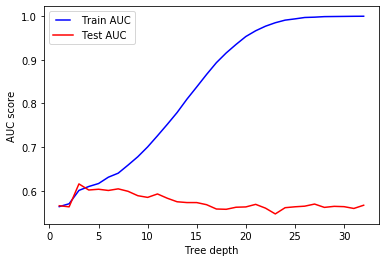

In [384]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(x_train, y_train)
    train_pred = dt.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [385]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    dcModel=DecisionTreeClassifier(max_depth=3,random_state=42)
    dcModel.fit(trainX,trainY)
    validation=dcModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
Model_score=Model_score.append({'Classifier':'Decision tree','Model':'Enhanced model with all feature','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

In [386]:
Model_score

,Classifier,Model,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,0.613128,0.614045,0.570019,0.623999
1,Logistic,Base model with dropping gender,0.613501,0.614448,0.569460,0.624633
2,Logistic,Base model with dropping time_in_hospital,0.609777,0.610618,0.567784,0.619807
3,Logistic,Base model with dropping num_lab_procedures,0.614525,0.615451,0.571695,0.625487
4,Logistic,Base model with dropping num_procedures,0.609777,0.610659,0.566480,0.620272
5,Logistic,Base model with dropping num_medications,0.613408,0.614390,0.570764,0.624387
6,Logistic,Base model with dropping number_outpatient,0.613315,0.614218,0.570764,0.624123
7,Logistic,Base model with dropping number_emergency,0.610987,0.611907,0.567784,0.621681
8,Logistic,Base model with dropping number_inpatient,0.597114,0.597234,0.594227,0.597983
9,Logistic,Base model with dropping number_diagnoses,0.603352,0.605208,0.537989,0.619027


In [387]:
DC_feature_importance=pd.DataFrame(Diabetic_data_prep_x.columns, dcModel.feature_importances_).reset_index()
DC_feature_importance.columns=['Importance','Feature']

In [388]:
DC_feature_importance.sort_values('Importance',ascending=False)

,Importance,Feature
6,0.575577,number_inpatient
18,0.177950,admission_source_UNK
7,0.154199,number_diagnoses
0,0.092274,time_in_hospital
31,0.000000,admission_type_Emergency
30,0.000000,admission_type_Elective
32,0.000000,admission_type_Trauma Center
33,0.000000,admission_type_UNK
29,0.000000,gender_Male
19,0.000000,diag_1_group_Circulatory


In [389]:
## visualize tree

In [390]:
from IPython.display import Image  
from sklearn import tree
import pydotplus # installing pyparsing maybe needed


In [391]:
# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(dcModel, out_file='tree.dot', 
#                 feature_names = Diabetic_data_prep_x.columns,
#                 class_names = ['0','1'],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# #from IPython.display import Image
#Image(filename = 'tree.png')

In [392]:
# graph =  pydotplus.graphviz.graph_from_dot_file("tree.dot")
# #Image(graph.create_png())
# graph

## 5.2 Random forest for enhanced model

### Grid search parameter for random forest classifier

In [393]:
from sklearn.model_selection import GridSearchCV
randomforest = RandomForestClassifier(random_state = 7, n_estimators= 100, n_jobs= -1)

In [394]:
x_train, x_test, y_train, y_test = train_test_split(scaled_Diabetic_data_prep_x, Diabetic_data_prep_y, test_size=0.25,random_state=0)

In [395]:
param_RF = {'max_depth' : [4, 5,6,7],
           'n_estimators': [50, 150, 100, 200, 300, 350, 400],
           'min_samples_split': [2, 3, 4],
           'min_samples_leaf': [2, 5]}

randomRF = GridSearchCV(randomforest, param_RF,cv = 5,n_jobs=-1)
randomRF.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=7,
                                     

In [396]:
print(randomRF.best_params_)
print(randomRF.best_score_)

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
0.6139044072004965


### Develop random forest model

In [397]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    rfModel = RandomForestClassifier(max_depth=6,min_samples_leaf=2,min_samples_split=2,n_estimators = 50, random_state = 42)
    rfModel.fit(trainX,trainY)
    validation=rfModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
Model_score=Model_score.append({'Classifier':'Random forest','Model':'Enhanced model with all feature','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

In [398]:
Model_score

,Classifier,Model,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,0.613128,0.614045,0.570019,0.623999
1,Logistic,Base model with dropping gender,0.613501,0.614448,0.569460,0.624633
2,Logistic,Base model with dropping time_in_hospital,0.609777,0.610618,0.567784,0.619807
3,Logistic,Base model with dropping num_lab_procedures,0.614525,0.615451,0.571695,0.625487
4,Logistic,Base model with dropping num_procedures,0.609777,0.610659,0.566480,0.620272
5,Logistic,Base model with dropping num_medications,0.613408,0.614390,0.570764,0.624387
6,Logistic,Base model with dropping number_outpatient,0.613315,0.614218,0.570764,0.624123
7,Logistic,Base model with dropping number_emergency,0.610987,0.611907,0.567784,0.621681
8,Logistic,Base model with dropping number_inpatient,0.597114,0.597234,0.594227,0.597983
9,Logistic,Base model with dropping number_diagnoses,0.603352,0.605208,0.537989,0.619027


In [399]:
RF_feature_importance=pd.DataFrame(scaled_Diabetic_data_prep_x.columns,rfModel.feature_importances_).reset_index()
RF_feature_importance.columns=['Importance','Feature']

In [400]:
RF_feature_importance.sort_values('Importance',ascending=False)

,Importance,Feature
6,0.258096,number_inpatient
7,0.139185,number_diagnoses
0,0.101076,time_in_hospital
3,0.068116,num_medications
1,0.056804,num_lab_procedures
18,0.045630,admission_source_UNK
33,0.034347,admission_type_UNK
5,0.032989,number_emergency
2,0.023598,num_procedures
4,0.023445,number_outpatient


## 5.3 SVM for enhanced model

In [401]:
from sklearn import svm
from sklearn.svm import SVC

### parameter grid search

In [402]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
randomSVM = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
randomSVM.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.504, total=   4.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.504, total=   4.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.504, total=   4.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.504, total=   3.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.504, total=   3.7s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.587, total=   3.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.584, total=   3.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.573, total=   3.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.574, total=   3.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.590, total=   3.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.604, total=   3.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.589, total=   3.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.595, total=   3.5s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.628, total=   3.5s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.624, total=   2.9s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.608, total=   2.9s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.585, total=   6.7s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] ..... C=1000, gamma=0.001, kernel=rbf, score=0.617, total=   6.5s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.621, total=   3.6s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.610, total=   4.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.601, total=   4.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.595, total=   3.7s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.631, total=   3.6s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 10.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [403]:
print(randomSVM.best_params_) 
print(randomSVM.best_estimator_) 

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### Develop SVM model

In [404]:
score=pd.DataFrame(columns=['Accuracy','AUC','Precision','Recall'])
cv_splits=StratifiedKFold(10,True,123)
for train_index,test_index,in cv_splits.split(scaled_Diabetic_data_prep_x,Diabetic_data_prep_y):
    trainX=Diabetic_data_prep_x.iloc[train_index,]
    trainY=Diabetic_data_prep_y.iloc[train_index,]
    
    testX=Diabetic_data_prep_x.iloc[test_index,]
    testY=Diabetic_data_prep_y.iloc[test_index,]
    
    svmModel = svm.SVC(kernel='rbf',gamma=0.001,C=10)
    svmModel.fit(trainX,trainY)
    validation=svmModel.predict(testX)
    
    fold_accuracy=accuracy_score(validation,testY)
    fold_precision=precision_score(validation,testY)
    fold_recall=recall_score(validation,testY)
    fold_auc=roc_auc_score(validation,testY)
    score=score.append({'Accuracy':fold_accuracy,'AUC':fold_auc,'Precision':fold_precision,'Recall':fold_recall},ignore_index=True)
    
    
Model_score=Model_score.append({'Classifier':'SVM','Model':'Enhanced model with all feature','Accuracy':score.Accuracy.mean(),'AUC':score.AUC.mean(),'Precision':score.Precision.mean(),'Recall':score.Recall.mean()},ignore_index=True)    

In [405]:
Model_score

,Classifier,Model,Accuracy,AUC,Precision,Recall
0,Logistic,Base model with all features,0.613128,0.614045,0.570019,0.623999
1,Logistic,Base model with dropping gender,0.613501,0.614448,0.569460,0.624633
2,Logistic,Base model with dropping time_in_hospital,0.609777,0.610618,0.567784,0.619807
3,Logistic,Base model with dropping num_lab_procedures,0.614525,0.615451,0.571695,0.625487
4,Logistic,Base model with dropping num_procedures,0.609777,0.610659,0.566480,0.620272
5,Logistic,Base model with dropping num_medications,0.613408,0.614390,0.570764,0.624387
6,Logistic,Base model with dropping number_outpatient,0.613315,0.614218,0.570764,0.624123
7,Logistic,Base model with dropping number_emergency,0.610987,0.611907,0.567784,0.621681
8,Logistic,Base model with dropping number_inpatient,0.597114,0.597234,0.594227,0.597983
9,Logistic,Base model with dropping number_diagnoses,0.603352,0.605208,0.537989,0.619027


In [412]:
import datetime
now = datetime.datetime.now()
date=now.strftime("%Y_%m_%d")

### Export result

In [414]:
Model_score.to_csv(r'D:\Yafen\study\UHG DSU\my project\dataset_diabetes\model performance score'+date+'.csv')

In [416]:
Model_by_diag_score.to_csv(r'D:\Yafen\study\UHG DSU\my project\dataset_diabetes\Model_by_diag_score'+date+'.csv')